# 蚁群算法（antColonyAlgorithm）实现商旅问题（TSP）
## 背景
旅行商问题（最短路径问题）（英语：travelling salesman problem, TSP）是这样一个问题：给定一系列城市和每对城市之间的距离，求解访问每一座城市一次并回到起始城市的最短回路。它是组合优化中的一个NP困难问题，在运筹学和理论计算机科学中非常重要。  
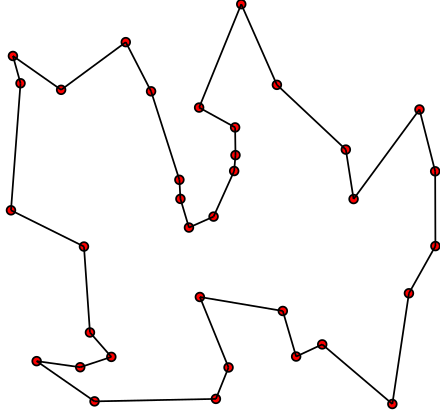  
商旅问题在组合优化中是 NP-hard问题;  
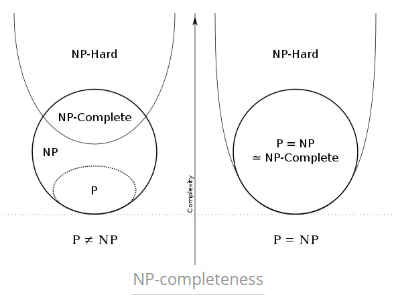  
关于 P、NP、NP-hard、NP-C问题，做了如下总结；  
* P问题：计算时间与计算复杂度/样本成倍数关系；
* NP问题：计算时间与复杂度/样本成指数关系（复杂度/样本量越大，计算量/时间越大）；或目前上，无法对其做一般性的归纳总结，如百度百科找出最大质数问题等等；
* NP-hard问题：简单的示例是子集集合问题，是在 N=NP 条件下，NP问题 是 NP-hard问题 的子集；
* NP完全问题：满足 NP问题 和 NP-hard 问题，在特定条件下，众多 NP问题 可归纳为某一类 NP问题，解决了归纳的 NP问题，就解决了该集合内的所有 NP问题；

## 实现

蚁群算法是一种仿生学启发式算法，其核心思想在于模仿现实世界中蚂蚁寻找最优路径的生物机制，在1991年首次被提出(Colorni et al., 1991)，如今已经产生了很多应用成果(Dorigo and Stützle, 2010)，而BW这个加速收敛的方法则第一次出现在2000年(Cordon et al., 2000)。感兴趣的同学可以仔细研究一下参考文献：  
* Colorni, A., Dorigo, M., Maniezzo, V., 1991. Distributed optimization by ant colonies, Proceedings of the first European conference on artificial life. Paris, France, pp. 134-142.
* Cordon, O., de Viana, I.F., Herrera, F., Moreno, L., 2000. A new ACO model integrating evolutionary computation concepts: The best-worst Ant System, From Ant Colonies to Artificial Ants: Second International Workshop on Ant Algorithms Brussels, Belgium.  
* Dorigo, M., Stützle, T., 2010. Ant colony optimization: overview and recent advances, Handbook of metaheuristics. Springer, pp. 227-263.  

本文蚁群算法经过了修改以适应具体问题，流程为：  
* 1、设置n只蚂蚁在起点，初始化每条边的phenomenon量
* 2、每只蚂蚁按照转移概率函数构建路径
* 3、根据等待时长挑出最优路径和最差路径，对每条在最优路径中的边，增加一个固定的phenomenon量，对最差路径中的则减去同等的量，并根据挥发系数减去一个固定百分比的量
* 4、重复2-3步直至maximum iteration，输出最优路径  

算法流程图：  
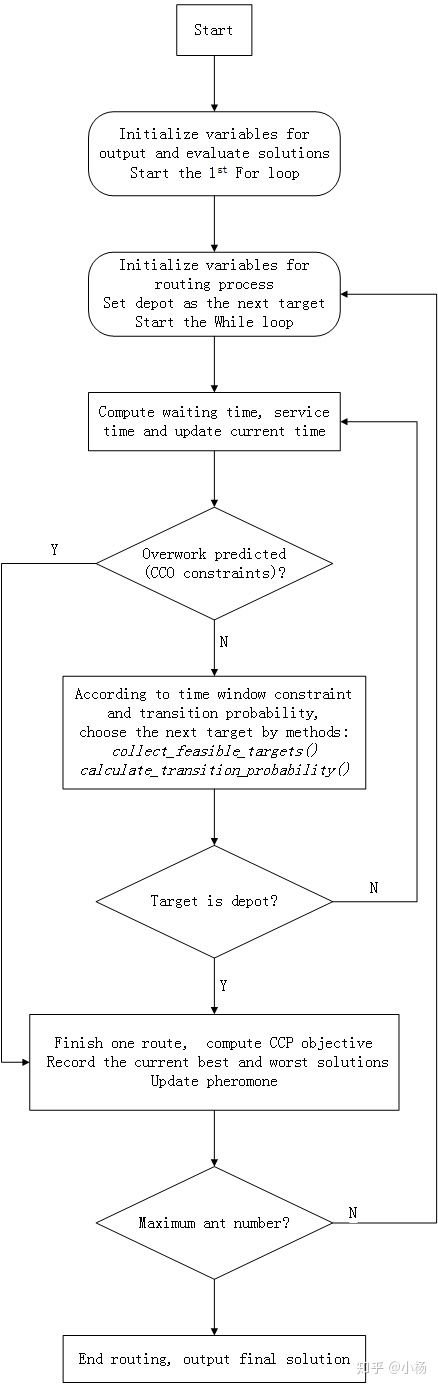  


In [1]:
import copy

In [2]:
def aco(acquaintance_increment,alpha_model_p,beta_model_p,waiting_limit,workload,alpha_aco_p,beta_aco_p,rho_aco_p,ant_num,pheromone_matrix,walk_speed,preference_matrix,distance_matrix,service_time_mean,nurse,sd_matched_targets,depot):
    # 输出变量
    arrival_time_trace = []
    shortest_time = 0
    waiting_time = 0
    best_path = []
    
    # 时间(temporal)变量
    worst_path = []
    ccp_best_objective = 0
    cpp_worst_objective = 0
    
    # n只蚂蚁构建n条路径
    for ant in range(ant_num):
        # 初始化：depot、time、waiting time、workload
        current_job = depot
        current_time = 0
        current_waiting = 0
        current_workload = 0
    
        # 初始化列表记录时间和路径
        sub_arrival_time = []
        ant_path_table = [depot]
        
        # 初始化访问列表和偏好矩阵
        visitiong_list = copy.deepcopy(sd_matched_targets)
        current_preference = copy.deepcopy(preference_matrix)
        
        # 计算路线
        # 每一只蚂蚁都要在workload约束下适时结束旅途
        while current_workload < workload:
            # 读出服务时间平均值和偏好值
            st_mean = service_time_mean[nurse.s][current_job.lv]
            preference_factor = copy.deepcopy(current_preference[current_job.e][nurse.l])
            
            # 检查等待并记录到达时间
            if current_time < current_job.twb:
                current_waiting += (current_job.twb - current_time)
                current_time = copy.deepcopy(current_job.twb)
                sub_arrival_time.append(copy.deepcopy(current_time))
            else:
                sub_arrival_time.append(copy.deepcopy(current_time))
                
            # 将到达时间计算为返回当前位置的仓库时的预测工作量
            # 然后检查是否过劳
            current_workload = current_time + (preference_factor * st_mean) + beta_model_p + (distance_matrix[current_job.e][depot.e]) / walk_speed
            if current_workload >= workload:
                # 加班预测，停止路由
                # 将仓库设置为下一个目标并记录到达时间
                ant_path_table.append(depot)
                current_time = copy.deepcopy(current_workload)
                sub_arrival_time.append(copy.deepcopy(current_time))
                break
            else:
                # 继续路由
                # 累加服务时间
                current_time += (preference_factor * st_mean) + alpha_model_p
            
            # 搜索满足时间窗口约束的目标
            feasible_targets = collect_feasible_targets(visiting_list,distance_matrix,walk_speed,waiting_limit,current_job,current_time)
            # 计算可行目标，计算转移概率并选择目标
            chosen_target = calculate_transition_probability(feasible_targets,current_time,distance_matrix,current_job,walk_speed,sub_arrival_time,ant_path_table,visiting_list,pheromone_matrix,alpha_aco_p,beta_aco_p,depot)
            if chosen_target.l == 0:
                # 没有可行目标，停止路由
                break
            else:
                # 选择了可行的目标，继续
                current_job = chosen_target
                # 修改偏好
                current_preference[chosen_target.e][nurse.l] -= acquaintance_increment
                continue
        
        # 计算满足的需求
        fulfilled_demand = copy.deepcopy(len(ant_path_table) -  2)
        # 根据CCP目标记录最佳和最差解决方案
        if fulfilled_demand == 0:
            # 没有满足的需求
            if len(best_path) == 0:
                best_path = copy.deepcopy(ant_path_table)
                worst_path = copy.deepcopy(ant_path_table)
        else:
            # 记录当前 PPM 目标：总等待时间
            ccp_objective = copy.deepcopy(current_copy)
            if ant == 0:
                # 第一次迭代，记录最佳 CCP 目标、最差 PPM 目标、工作时间、等待时间、最佳路线和最差路线
                cpp_best_objective = copy.deepcopy(cpp_objective)
                cpp_worst_objective = copy.deepcopy(cpp_objective)
                shortest_time = copy.deepcopy(current_time)
                waiting_time = copy.deepcopy(current_waiting)
                best_path = copy.deepcopy(ant_path_table)
                worst_path = copy.deepcopy(ant_path_table)
                arrival_time_trace = copy.deepcopy(sub_arrival_time)
            else: # 非第一次迭代
                if cpp_best_objective > cpp_objective: # 寻找最佳
                    cpp_best_objective = copy.deepcopy(cpp_objective)
                    shortest_time = copy.deepcopy(current_time)
                    waiting_time = copy.deepcopy(current_waiting)
                    best_path = copy.deepcopy(ant_path_table)
                    arrival_time_trace = copy.deepcopy(sub_arrvial_time)
                elif cpp_worst_objective < cpp_objective: # 寻找最差
                    cpp_worst_objective = copy.deepcopy(cpp_objective)
                    worst_path = copy.deepcopy(ant_path_table)
                else:
                    continue
        
        # 根据最佳-最差规则更新信息素
        update_pheromone(best_path,worst_path,pheromone_matrix,rho_aco_p,distance_matrix)
    
    # 更新路由
    nurse.tt = copy.deepcopy(shortest_time)
    nurse.aT = copy.deepcopy(arrival_time_trace)
    nurse.twt = copy.deepcopy(waiting_time)
    for o in range(len(best_path)):
        nurse.r.append(best_path[o])
        if best_path[o].lv == 1:
            nurse.sd[0] += 1
        elif best_path[o].lv == 2:
            nurse.sd[1] += 1
        elif best_path[o].lv == 3:
            nurse.sd[2] += 1
    if sum(nurse.sd) != 0:
        nurse.avg_w = copy.deepcopy(nurse.twt / sum(nurse.sd))

In [3]:
def collect_feasible_targets(visiting_list,distance_matrix,walk_speed,waiting_limit,current_job,current_time):
    ft = []
    for j in range(len(visiting_list)):
        distance = distance_matrix[current_job.e][visiting_list[j].e]
        travel = distance / walk_speed
        arrival = current_time + travel
        # 到达时间必须早于上限并且晚于最长等待时间 + 下限
        if arrival < visiting_list[j].twe:
            if (arrival + waiting_limit) >= visiting_list[j].twb:
                ft.append(visiting_list[j])
                continue
        else:
            continue
    return ft

这个函数是将所有满足时间窗基本要求的目标挑出来，所以对所有可选目标计算到达时刻，返回值是一个列表。再把这个列表抛给选择移动目标的函数：

In [ ]:
def calculate_transition_probability(feasible_targets,current_time,distance_matrix,current_job,walk_speed,sub_arrival_time,ant_path_table,visiting_list,pheromone_matrix,alpha_aco_p,beta_aco_p,depot):
    # 计算可行目标
    # =0: return depot as the next target
    # =1: return it as the next target
    # >2: return the target chosen according to probability transition function
    